# Draft `pyGIMLi(emg3d)` - Data Creation

**An attempt at using `pyGIMLi` as an inversion framework for `emg3d` computations.**

=> Create an environment using the provided `environment.yml`: `mamba env create`.

For developing purposes, we take a very simple grid/model/survey:
- Coarse mesh, no stretching (potentially too small).
- Simple double-halfspace model water-subsurface with a resistive block.
- Survey: A single 2D line, 5 sources (3 in the coarse one), 1 frequency.

=> For this dev-implementation we also do inversion crime, using the same grid for forward modelling and inversion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
import emg3d

## Coarse-flag
- Coarse model: 3 src, 57 rec, 1 freq; 32 x 16 x 16 = 8,192 cells 
- Fine model: 5 src, 57 rec, 1 freq; 64 x 32 x 32 = 65,536 cells

In [3]:
#coarse = True
coarse = False

## Create a survey

In [4]:
azimuth = 0.0
elevation = 0.0

# Receiver line
rec_x = np.arange(-7000, 7001, 250.)
rec_y = 0.0
rec_z = 0.0
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (rec_x, rec_y, rec_z, azimuth, elevation)
)

# Sources
if coarse:
    src_x = np.array([-5000, 0.0, 5000])
    src_y = 250.0
else:
    src_x = np.array([-5000, -2500, 0.0, 2500, 5000])
    src_y = 125.0
src_z = 50.0
src = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.TxElectricDipole,
        (src_x, src_y, src_z, azimuth, elevation),
        strength=1000,
)

frequencies = np.array([1.0, ])

survey = emg3d.surveys.Survey(
    sources=src,
    receivers=rec,
    frequencies=frequencies,
    noise_floor=1e-17,
    relative_error=0.05,
)

# QC
survey

:: Survey ::

<xarray.Dataset>
Dimensions:   (src: 5, rec: 57, freq: 1)
Coordinates:
  * src       (src) <U6 'TxED-1' 'TxED-2' 'TxED-3' 'TxED-4' 'TxED-5'
  * rec       (rec) <U7 'RxEP-01' 'RxEP-02' 'RxEP-03' ... 'RxEP-56' 'RxEP-57'
  * freq      (freq) <U3 'f-1'
Data variables:
    observed  (src, rec, freq) complex128 (nan+nanj) (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-17
    relative_error:  0.05

## Create a simple model

In [5]:
if coarse:
    hx = np.ones(32)*500.0
    hyz = np.ones(16)*500.0
else:
    hx = np.ones(64)*250.0
    hyz = np.ones(32)*250.0
grid = emg3d.TensorMesh([hx, hyz, hyz], [-8125, -4000, -4000])

# QC
grid

TensorMesh: 65,536 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64     -8,125.00      7,875.00    250.00    250.00    1.00
   y     32     -4,000.00      4,000.00    250.00    250.00    1.00
   z     32     -4,000.00      4,000.00    250.00    250.00    1.00

Model: resistivity; isotropic; 64 x 32 x 32 (65,536)

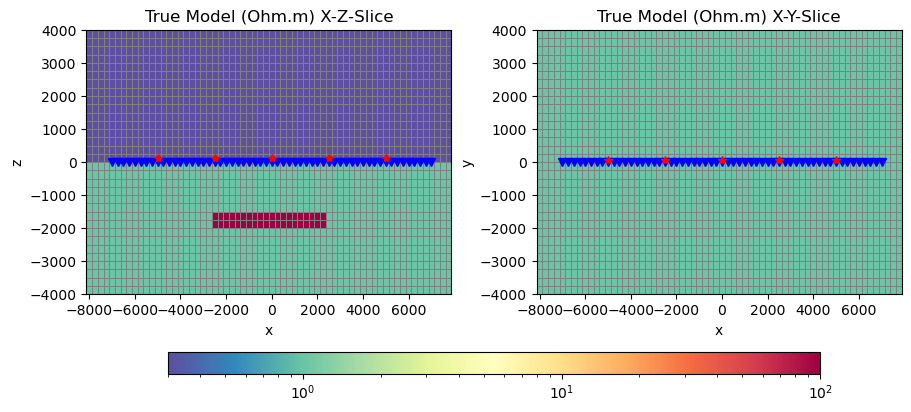

In [6]:
# Initial model
model = emg3d.Model(grid, 1.0)
if coarse:
    model.property_x[:, :, 8:] = 0.3
else:
    model.property_x[:, :, 16:] = 0.3

# Model with a target
tg_model = model.copy()
if coarse:
    tg_model.property_x[10:-10, 2:-2, 3:5] = 100.0
else:
    tg_model.property_x[22:-22, 5:-5, 8:10] = 100.0

popts = {'edgecolors': 'grey', 'linewidth': 0.5, 'cmap':'Spectral_r','norm':LogNorm(vmin=0.3, vmax=100)}
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, sharex=True)

opts = {'v_type': 'CC', 'normal': 'Y', 'pcolor_opts': popts}
out1, = grid.plot_slice(tg_model.property_x.ravel('F'), ax=ax1, **opts)
ax1.set_title(f"True Model (Ohm.m) X-Z-Slice")
ax1.plot(rec_coords[0], rec_coords[1], 'bv')
ax1.plot(src_coords[0], src_coords[1], 'r*')
    
opts = {'v_type': 'CC', 'normal': 'Z', 'pcolor_opts': popts}
out2, = grid.plot_slice(tg_model.property_x.ravel('F'), ax=ax2, ind=1, **opts)
ax2.set_title(f"True Model (Ohm.m) X-Y-Slice")
ax2.plot(rec_coords[0], rec_coords[2], 'bv')
ax2.plot(src_coords[0], src_coords[2], 'r*')

plt.colorbar(out1, ax=(ax1, ax2), orientation='horizontal', fraction=.1, shrink=.8, aspect=30)

# QC
tg_model

## Generate synthetic data

In [7]:
simulation = emg3d.simulations.Simulation(
    survey=survey,
    model=tg_model,
    gridding='same',
    max_workers=6,
    receiver_interpolation='linear',  # Currently necessary for the gradient
    # solver_opts,
)

# Let's QC our Simulation instance
simulation

:: Simulation ::

- Survey: 5 sources; 57 receivers; 1 frequencies
- Model: resistivity; isotropic; 64 x 32 x 32 (65,536)
- Gridding: Same grid as for model; 64 x 32 x 32 (65,536)

In [8]:
simulation.compute(observed=True, min_offset=1000)
del survey.data['synthetic']  # Observed (with noise) remains stored

Compute efields            0/5  [00:00]

In [9]:
if coarse:
    emg3d.save('pginv-coarse.h5', model=model, survey=survey, true_model=tg_model)
else:
    emg3d.save('pginv-fine.h5', model=model, survey=survey, true_model=tg_model)

Data saved to «/palmyra/data/dieterwerthmul/dev-pygimli-emg3d/pginv-fine.h5»
[emg3d v1.8.1 (format 1.0) on 2023-12-18T22:04:00.387774].


## Compute responses for initial model, QC that the data is sensitive to the target

In [10]:
init_sim = emg3d.simulations.Simulation(
    survey=survey,
    model=model,
    gridding='same',
    max_workers=6,
    receiver_interpolation='linear',  # Currently necessary for the gradient
    # solver_opts,
)

init_sim.compute()

Compute efields            0/5  [00:00]

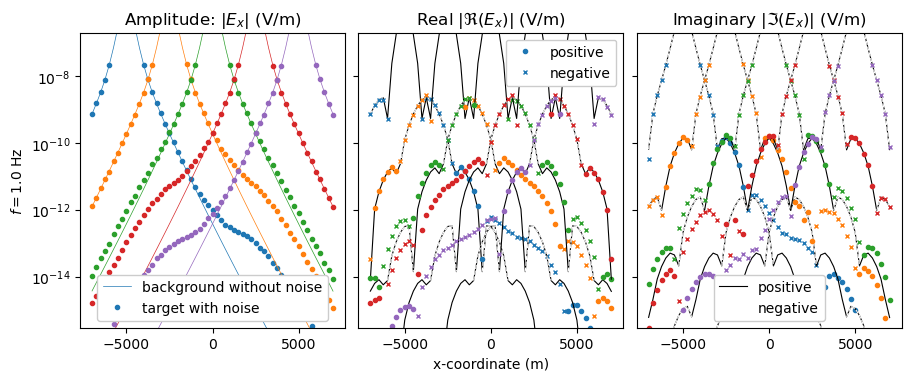

In [11]:
def pos(data):
    """Return positive data; set negative data to NaN."""
    return np.array([x if x > 0 else np.nan for x in data])


def neg(data):
    """Return -negative data; set positive data to NaN."""
    return np.array([-x if x < 0 else np.nan for x in data])

height = survey.shape[2]*1.7+2
fig, axs = plt.subplots(survey.shape[2], 3, figsize=(9, height), constrained_layout=True, sharex=True, sharey=True)
axs = np.atleast_2d(axs)  # So it works if only 1 freq

obs = init_sim.data.observed
syn = init_sim.data.synthetic
rec_coords = survey.receiver_coordinates()

for ii, freq in enumerate(survey.frequencies.keys()):
    for i, src in enumerate(survey.sources.keys()):
        #if i in [1, 3, 5]:
        #    continue
        
        axs[ii, 0].plot(rec_coords[0], abs(syn.loc[src, :, freq].data), f"C{i}-", lw=0.5,
                        label='background without noise' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], abs(syn.loc[src, :, freq].data.real), f"k-", lw=0.8)
        axs[ii, 1].plot(rec_coords[0], neg(syn.loc[src, :, freq].data.real), f"w--", lw=0.8)
        axs[ii, 2].plot(rec_coords[0], abs(syn.loc[src, :, freq].data.imag), f"k-", lw=0.8,
                        label='positive' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], neg(syn.loc[src, :, freq].data.imag), f"w--", lw=0.8,
                        label='negative' if i == 0 else '')
        
        axs[ii, 0].plot(rec_coords[0], abs(obs.loc[src, :, freq].data), f"C{i}.",
                        label='target with noise' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.real), f"C{i}.",
                        label='positive' if i == 0 else '')
        axs[ii, 1].plot(rec_coords[0], neg(obs.loc[src, :, freq].data.real), f"C{i}x", ms=3,
                        label='negative' if i == 0 else '')
        axs[ii, 2].plot(rec_coords[0], pos(obs.loc[src, :, freq].data.imag), f"C{i}.")
        axs[ii, 2].plot(rec_coords[0], neg(obs.loc[src, :, freq].data.imag), f"C{i}x", ms=3)

    axs[ii, 0].set_ylabel(f'$f={survey.frequencies[freq]}$ Hz')     

        
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim([3e-16, 2e-7])

axs[0, 0].set_title('Amplitude: $|E_x|$ (V/m)')
axs[0, 1].set_title('Real $|\Re(E_x)|$ (V/m)')
axs[0, 2].set_title('Imaginary $|\Im(E_x)|$ (V/m)')

axs[0, 0].legend(framealpha=1)
axs[0, 1].legend(framealpha=1)
axs[0, 2].legend(framealpha=1)

axs[-1, 1].set_xlabel('x-coordinate (m)')
plt.show()

In [12]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Mon Dec 18 22:04:03 2023 CET

                OS : Linux
            CPU(s) : 256
           Machine : x86_64
      Architecture : 64bit
               RAM : 1007.1 GiB
       Environment : Jupyter
       File system : xfs

  Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06)
  [GCC 11.3.0]

             numpy : 1.23.5
             scipy : 1.10.1
             numba : 0.56.4
             emg3d : 1.8.1
           empymod : 2.2.1
            xarray : 2023.4.2
        discretize : 0.8.3
              h5py : 3.8.0
        matplotlib : 3.7.1
              tqdm : 4.65.0
           IPython : 8.13.2
--------------------------------------------------------------------------------